In [18]:
import numpy as np
import pandas as pd 

DATA = "C:\\Users\\aryan\\Desktop\\derma_diagnosis_ai\\derma_diagnosis_ai\\data\\processed\\dermatology.csv"
df = pd.read_csv(DATA)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   erythema                             366 non-null    int64  
 1   scaling                              366 non-null    int64  
 2   definite_borders                     366 non-null    int64  
 3   itching                              366 non-null    int64  
 4   koebner_phenomenon                   366 non-null    int64  
 5   polygonal_papules                    366 non-null    int64  
 6   follicular_papules                   366 non-null    int64  
 7   oral_mucosal                         366 non-null    int64  
 8   knee_elbow                           366 non-null    int64  
 9   scalp                                366 non-null    int64  
 10  family_history                       366 non-null    int64  
 11  exocytosis                      

erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal                           0
knee_elbow                             0
scalp                                  0
family_history                         0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary                0
spongiform_pustule                     0
munro_microabcess                      0
focal_hypergranulosis                  0
disappearance_granular_layer           0
vacuolisation_damage                   0
spongiosis                             0
saw_tooth_appear

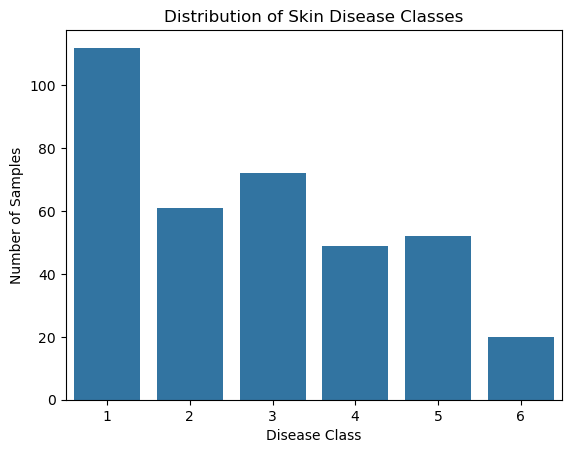

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title("Distribution of Skin Disease Classes")
plt.xlabel("Disease Class")
plt.ylabel("Number of Samples")
plt.show()


From the above data set we can say 
| Class                    | Count   | Share |
| ------------------------ | ------- | ----- |
| Psoriasis                | **112** | 31 %  |
| Seborrheic dermatitis    | 61      | 17 %  |
| Lichen planus            | 72      | 20 %  |
| Pityriasis rosea         | 49      | 13 %  |
| Chronic dermatitis       | 52      | 14 %  |
| Pityriasis rubra pilaris | **20**  | 5 %   |

we can use  balancing techniques later to account for this uneven share although there wont be significant performance improvement by using it
 

erythema
0      4
1     57
2    215
3     90


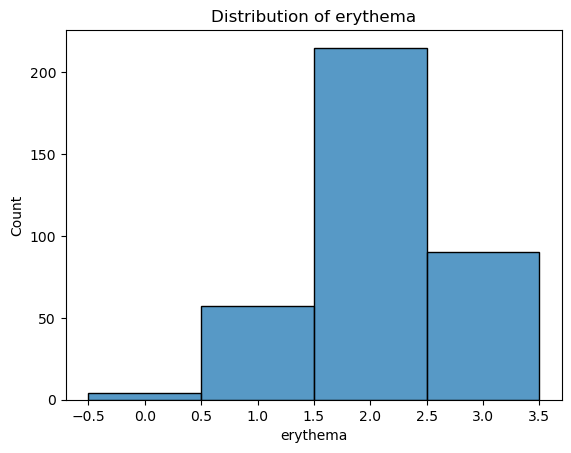

scaling
0      8
1    111
2    195
3     52


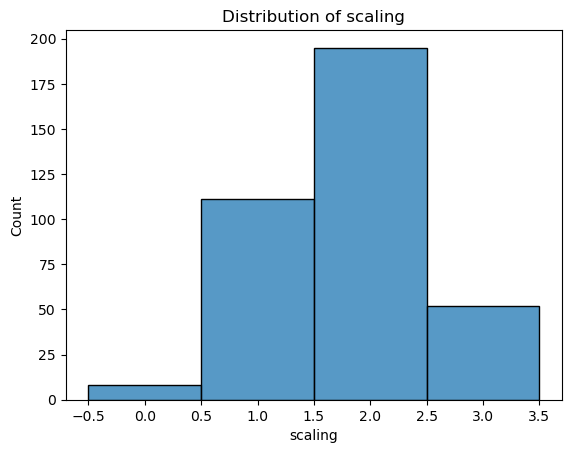

definite_borders
0     59
1     93
2    168
3     46


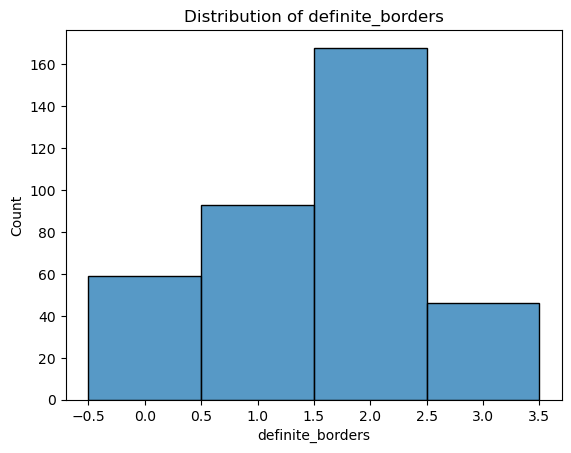

itching
0    118
1     72
2    100
3     76


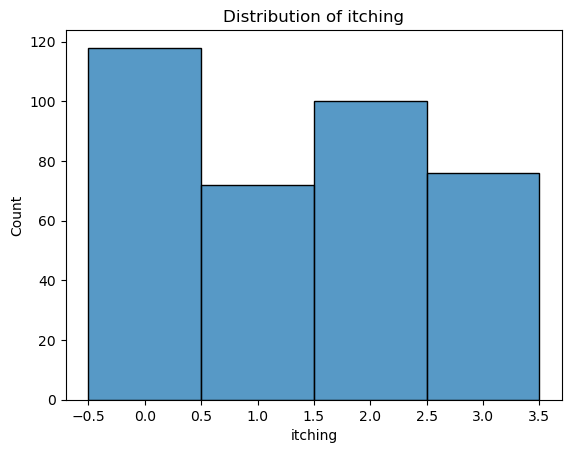

koebner_phenomenon
0    224
1     70
2     54
3     18


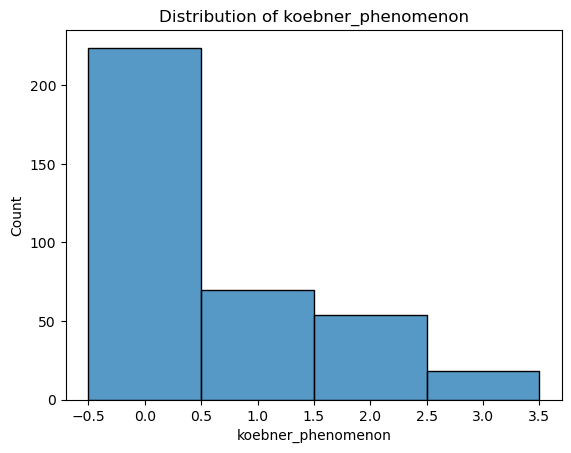

In [20]:
for col in df.columns[:5]:  # Just a few first features to start 
# If you want to analyze all features remove the slicing [:5]
    
    counts = df[col].value_counts().sort_index()
    print(counts.to_string())  
    
    
    
    sns.histplot(df[col], bins=[-0.5,0.5,1.5,2.5,3.5], discrete=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


the above code is used to visualize the distribution of the features in the dataset 
Now we analyze Feature vs Disease (target) to see how features relate to the target variable

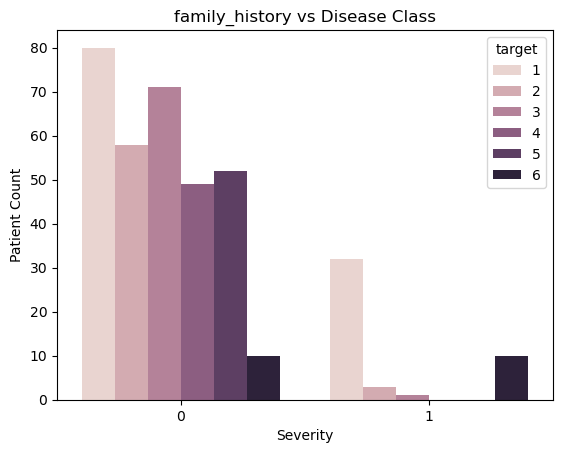

In [21]:
Feature_name = "family_history"  # Change this to any feature you want to visualize
sns.countplot(x=Feature_name, hue='target', data=df)
plt.title(f"{Feature_name} vs Disease Class")

# give ONE clean label
plt.xlabel("Severity")         
plt.ylabel("Patient Count")

plt.show()


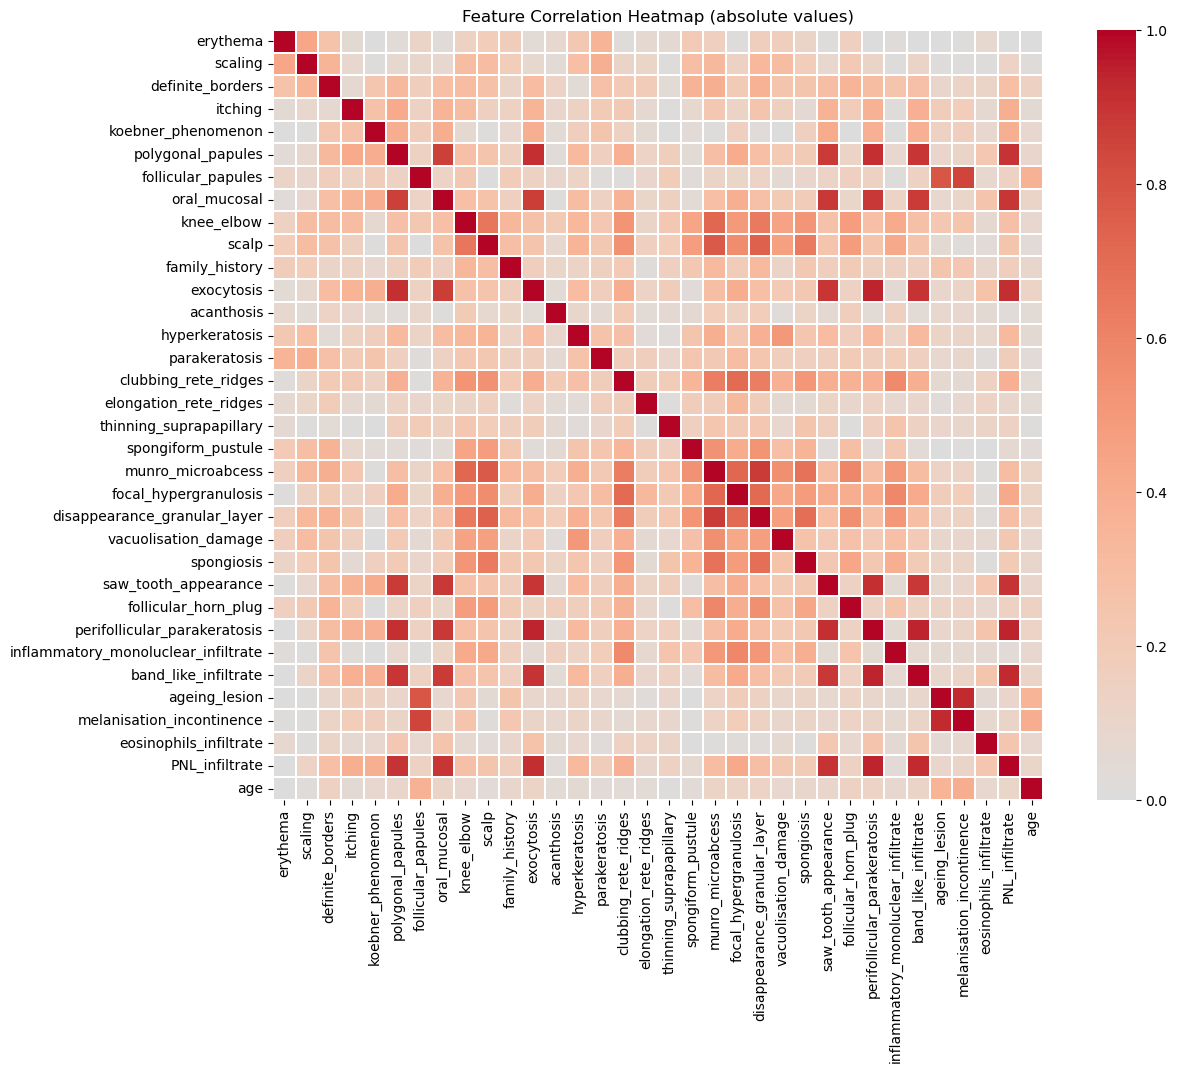

In [22]:
feature_df = df.drop(columns=["target"])

# Compute absolute Pearson correlations
corr = feature_df.corr().abs()

# Make the plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    vmax=1,
    vmin=0,
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 1},
)
plt.title("Feature Correlation Heatmap (absolute values)")
plt.show()


In [23]:
# Compute correlation matrix (absolute values)
corr_matrix = df.drop(columns=["target"]).corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find feature pairs with correlation > 0.95
high_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_A", "level_1": "Feature_B", 0: "Correlation"})
    .query("Correlation > 0.85")
    .sort_values(by="Correlation", ascending=False)
)

# Display the result
print("Highly correlated feature pairs (correlation > 0.95):")
print(high_corr.to_string(index=False))


Highly correlated feature pairs (correlation > 0.95):
                   Feature_A                    Feature_B  Correlation
                  exocytosis perifollicular_parakeratosis     0.941659
perifollicular_parakeratosis         band_like_infiltrate     0.938397
perifollicular_parakeratosis               PNL_infiltrate     0.937561
               ageing_lesion    melanisation_incontinence     0.928929
        band_like_infiltrate               PNL_infiltrate     0.928748
                  exocytosis               PNL_infiltrate     0.916848
           polygonal_papules perifollicular_parakeratosis     0.911626
        saw_tooth_appearance perifollicular_parakeratosis     0.909650
           polygonal_papules                   exocytosis     0.907044
           polygonal_papules               PNL_infiltrate     0.905822
        saw_tooth_appearance               PNL_infiltrate     0.904519
                  exocytosis         band_like_infiltrate     0.900232
                  exocy

as we are using xgboost multicollinearity is not a problem as it can handle it well  
still its few fetures 

In [24]:
#Now lets split the data into test train and validation sets
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight

X = df.drop("target", axis=1) 
Y = df["target"] - 1     

X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.40, stratify=Y, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.50, stratify=Y_temp, random_state=42)

w_train = compute_sample_weight("balanced", Y_train)

print("Train:",  X_train.shape[0],
      "Val:",    X_val.shape[0],
      "Test:",   X_test.shape[0])




Train: 219 Val: 73 Test: 74


after splitting the data we can now train the model using xgboost 

In [25]:
from xgboost import XGBClassifier


from sklearn import set_config
set_config(display="text")   # disables diagram display used just to supress the error message


model = XGBClassifier(
        objective="multi:softprob",
        num_class=6,
        n_estimators=500,
        learning_rate=0.04,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        early_stopping_rounds= 25  
)

model.fit(
    X_train,
    Y_train,
    sample_weight=w_train,           
    eval_set=[(X_val, Y_val)],       
    verbose=True                     
)


[0]	validation_0-mlogloss:1.70516
[1]	validation_0-mlogloss:1.63152
[2]	validation_0-mlogloss:1.55628
[3]	validation_0-mlogloss:1.49083
[4]	validation_0-mlogloss:1.42893
[5]	validation_0-mlogloss:1.37407
[6]	validation_0-mlogloss:1.32318
[7]	validation_0-mlogloss:1.27314
[8]	validation_0-mlogloss:1.22620
[9]	validation_0-mlogloss:1.18090
[10]	validation_0-mlogloss:1.14045
[11]	validation_0-mlogloss:1.10027
[12]	validation_0-mlogloss:1.06455
[13]	validation_0-mlogloss:1.03048
[14]	validation_0-mlogloss:0.99623
[15]	validation_0-mlogloss:0.96479
[16]	validation_0-mlogloss:0.93423
[17]	validation_0-mlogloss:0.90545
[18]	validation_0-mlogloss:0.87802
[19]	validation_0-mlogloss:0.85298
[20]	validation_0-mlogloss:0.82852
[21]	validation_0-mlogloss:0.80377
[22]	validation_0-mlogloss:0.78132
[23]	validation_0-mlogloss:0.75969
[24]	validation_0-mlogloss:0.74149
[25]	validation_0-mlogloss:0.71989
[26]	validation_0-mlogloss:0.69901
[27]	validation_0-mlogloss:0.68062
[28]	validation_0-mlogloss:0.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=25,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

0.22650 for 30
0.22706 for 15
0.22594 for 25
These are just for testing out perfect value for early stopping 



Now we test this model on the testing data and find out the result 

In [26]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))






Accuracy: 0.972972972972973
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      0.83      0.91        12
           2       1.00      1.00      1.00        15
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00        10
           5       0.80      1.00      0.89         4

    accuracy                           0.97        74
   macro avg       0.95      0.97      0.96        74
weighted avg       0.98      0.97      0.97        74



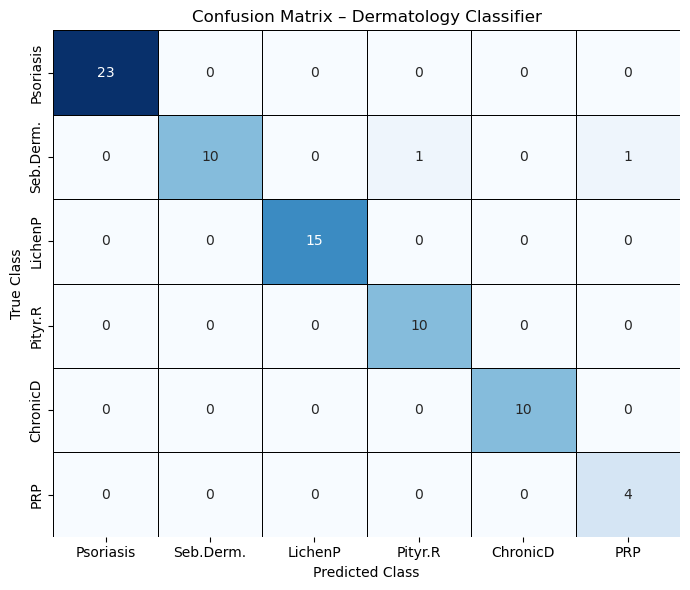

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd


cm   = confusion_matrix(Y_test, y_pred, labels=[0,1,2,3,4,5])
cm_df = pd.DataFrame(
    cm,
    index = ["Psoriasis","Seb.Derm.","LichenP","Pityr.R","ChronicD","PRP"],   # true classes
    columns= ["Psoriasis","Seb.Derm.","LichenP","Pityr.R","ChronicD","PRP"]   # predicted
)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=.5,
    linecolor="black"
)
plt.title("Confusion Matrix – Dermatology Classifier")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


In [28]:
# Class names in the order of model output
class_names = [
    "psoriasis",
    "seboreic dermatitis",
    "lichen planus",
    "pityriasis rosea",
    "chronic dermatitis",
    "prp"
]

import numpy as np

# Pick a random test sample each time
sample_idx = np.random.randint(0, X_test.shape[0])

# Get predicted probabilities for the sample
probs = y_pred_proba[sample_idx]
top_k = 3  # Number of top predictions to show

# Get top k predictions
top_indices = np.argsort(probs)[::-1][:top_k]

print("Prediction:")
for i, idx in enumerate(top_indices):
    icon = "🧪" if i < top_k - 1 else "🟢"
    print(f"{icon} {class_names[idx]}: {int(round(probs[idx]*100))}%")

print("\nExplanation (Top factors):")

# Get SHAP values for the predicted class
pred_class = top_indices[0]
shap_vals = shap_values[sample_idx, :, pred_class]
top_shap_idx = np.argsort(np.abs(shap_vals))[::-1][:3]

for idx in top_shap_idx:
    sign = "✔️" if shap_vals[idx] > 0 else "❌"
    feature = X_test.columns[idx]
    value = shap_vals[idx]
    print(f"{sign} {feature} ({value:+.2f})")

Prediction:
🧪 seboreic dermatitis: 72%
🧪 pityriasis rosea: 23%
🟢 psoriasis: 1%

Explanation (Top factors):
❌ clubbing_rete_ridges (-1.23)
✔️ hyperkeratosis (+1.03)
✔️ inflammatory_monoluclear_infiltrate (+0.69)
